# Notebook for evaluation and experiments on single state data

In [1]:
import sys
from pathlib import Path
import os

# Add the parent directory of this script to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

import torch
from settings import *
from helpers.simulation import *
from helpers.models import *
from helpers.eval import *
from helpers.training import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
color_opts = mcolors.CSS4_COLORS

## Bar plots from evaluation

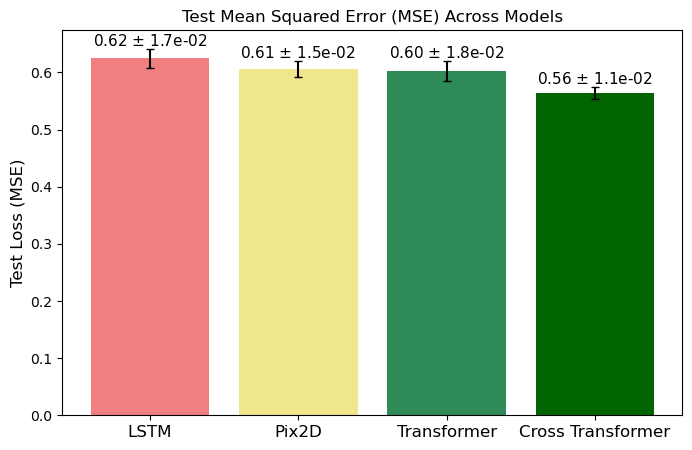

In [7]:
"""
Anisotropic case
"""
losses = [0.625, 0.606, 0.602, 0.564]
labels = ['LSTM', 'Pix2D', 'Transformer', 'Cross Transformer']
stds = [0.0168, 0.0147, 0.0177, 0.011]

fig, ax = plt.subplots(figsize=(8,5))
bar = ax.bar(labels, losses, color=[color_opts['lightcoral'], color_opts['khaki'], color_opts['seagreen'], color_opts['darkgreen']], yerr=stds, capsize=3)
ax.bar_label(bar, labels=[rf'{losses[i]:.2f} $\pm$ {stds[i]:.1e}' for i in range(4)], fontsize=11)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.tick_params('x', labelsize=12)
ax.set_title('Test Mean Squared Error (MSE) Across Models')
plt.show()

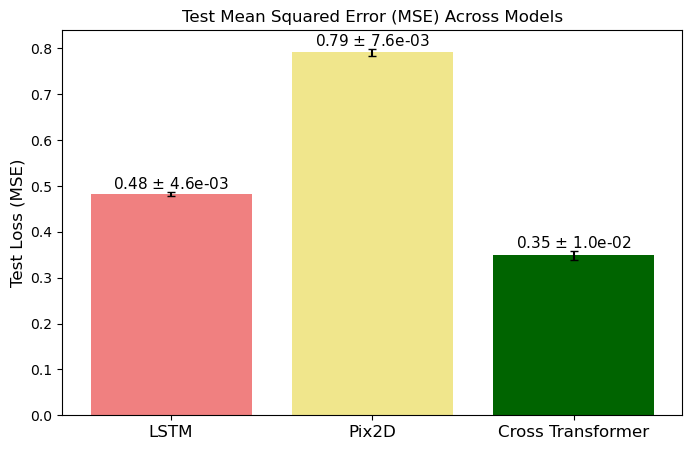

In [8]:
"""
Binding case
"""
losses = [0.483, 0.792, 0.349]
labels = ['LSTM', 'Pix2D', 'Cross Transformer']
stds = [0.00462, 0.00758, 0.00996]

fig, ax = plt.subplots(figsize=(8,5))
bar = ax.bar(labels, losses, color=[color_opts['lightcoral'], color_opts['khaki'], color_opts['darkgreen']], yerr=stds, capsize=3)
ax.bar_label(bar, labels=[rf'{losses[i]:.2f} $\pm$ {stds[i]:.1e}' for i in range(3)], fontsize=11)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.tick_params('x', labelsize=12)
ax.set_title('Test Mean Squared Error (MSE) Across Models')
plt.show()

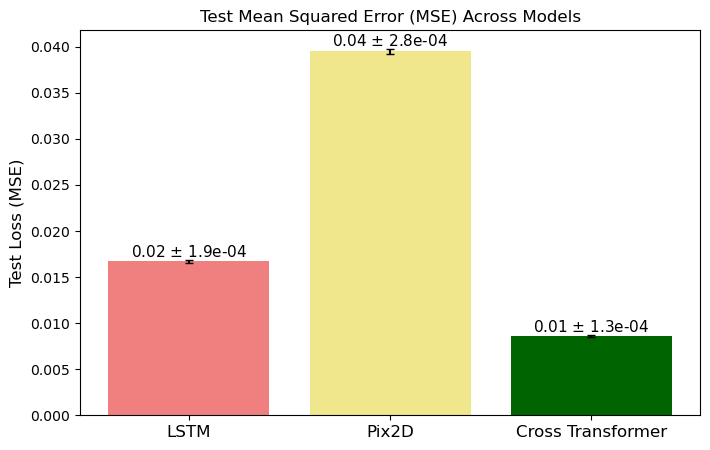

In [9]:
"""
Isotropic case
"""
losses = [0.0167, 0.0395, 0.00859]
labels = ['LSTM', 'Pix2D', 'Cross Transformer']
stds = [0.00019, 0.000284, 0.000129]

fig, ax = plt.subplots(figsize=(8,5))
bar = ax.bar(labels, losses, color=[color_opts['lightcoral'], color_opts['khaki'], color_opts['darkgreen']], yerr=stds, capsize=3)
ax.bar_label(bar, labels=[rf'{losses[i]:.2f} $\pm$ {stds[i]:.1e}' for i in range(3)], fontsize=11)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.tick_params('x', labelsize=12)
ax.set_title('Test Mean Squared Error (MSE) Across Models')
plt.show()

# Single state predictions

## Single mode

In [2]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.05,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "use_pos_embed": False,
    "use_segment_embed": True,
    "use_rotary": False
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = DiffusionTensorRegModelBase(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
        model_props['num_layers'], model_props['dropout'])

Using device: cuda


In [3]:
# Load pretrained model
model_path = '../results/image_only_300000_30_64_0.0001_0.05.pt'
checkpoint = torch.load(model_path, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

DiffusionTensorRegModelBase(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, ke

In [4]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = SINGLE_STATE_PROPS

#np.random.seed(1)
losses = []
for i in range(1):
    all_videos, og_labels = create_training_set(N, T, image_props)

    loss = single_state_eval(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

Average loss across validation set: 0.6176069161504697
Average MAE of diffusion coefficients and angle simularity across validation set: [0.35522908 0.2540273  0.8979668 ]
--------------------------------------------------
Average loss: 0.6176069161504697
Std of loss: 0.0


## Multi-modal

In [5]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.05,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "use_pos_embed": False,
    "use_segment_embed": True,
    "use_rotary": False
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CrossAttentionModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
    model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
    use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props['use_rotary'])

Using device: cuda


In [6]:
# Load pretrained model
model_path = '../results/model_325000_50_64_0.0001_0.01.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
disp_stats = checkpoint['norm_stats']
model.to(device)
model.eval()

CrossAttentionModel(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_siz

In [7]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = SINGLE_STATE_PROPS

#np.random.seed(1)

losses = []
for i in range(1):
    all_videos, all_displacements, og_labels = create_training_set_w_features(N, T, image_props)

    loss = single_state_eval(all_videos, all_displacements, og_labels, disp_stats, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

Average loss across validation set: 0.5559129193899738
Average MAE of diffusion coefficients and angle simularity across validation set: [0.35409138 0.24361654 0.90981025]
--------------------------------------------------
Average loss: 0.5559129193899738
Std of loss: 0.0


# Study performance with parameter variation

## PSF Variation

In [ ]:
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "use_pos_embed": False,
    "use_segment_embed": True,
    "use_rotary": False
}

image_props = SINGLE_STATE_PROPS

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CrossAttentionModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
    model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
    use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props['use_rotary'])

# Load pretrained model
model_path = '../results/model_325000_50_64_0.0001_0.01.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
disp_stats = checkpoint['norm_stats']
model.to(device)
model.eval()

Using device: cuda


CrossAttentionModel(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_siz

In [ ]:
"""
fwhm_psf = 0.51 * image_props['wavelength'] / image_props['NA'] # unit: m

# fwhm = 2.355 * sigma for a normal distribution then we need to correct for the upsampling and resolution
fwhm_px = fwhm_psf / resolution # units: pixel
gaussian_sigma = upsampling_factor * (fwhm_px / 2.355) # unit: upsampled pixels
"""

# Choose sigmas and calculate required aperture
sigmas = np.linspace(1, 3, num=5)
apertures =  0.51 * image_props['wavelength'] / image_props['resolution'] / 2.355 / sigmas

losses = []

for aperture in apertures:
    image_props['NA'] = aperture

    all_videos, all_displacements, og_labels = create_training_set_w_features(N, T, image_props)
    
    loss = single_state_eval(all_videos, all_displacements, og_labels, disp_stats, model, model_props['loss_fn'], image_props['D_max_norm'], device)
    
    losses.append(loss)

Average loss across validation set: 0.6181935787580575
Average MAE of diffusion coefficients and angle simularity across validation set: [0.6776937  0.5392064  0.90272814]
Average L2-based similarity of diffusion tensors across validation set: 0.9668104648590088
--------------------------------------------------
Average loss across validation set: 1.7155622904467736
Average MAE of diffusion coefficients and angle simularity across validation set: [2.5207345 3.1315517 0.7992495]
Average L2-based similarity of diffusion tensors across validation set: 0.6085548996925354
--------------------------------------------------
Average loss across validation set: 2.036927070587304
Average MAE of diffusion coefficients and angle simularity across validation set: [2.484091   3.0898616  0.74294585]
Average L2-based similarity of diffusion tensors across validation set: 0.6093112230300903
--------------------------------------------------
Average loss across validation set: 2.073196685238249
Average 

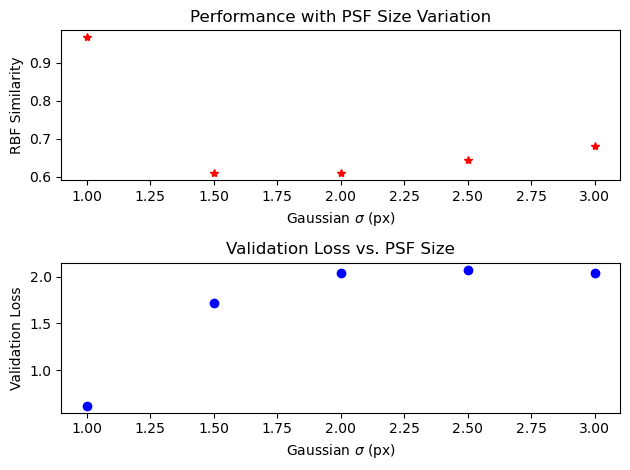

In [ ]:
fig, ax = plt.subplots(2,1)

ax.plot(sigmas, losses, 'bo')
ax.set_xlabel(r'Gaussian $\sigma$ (px)')
ax.set_ylabel('Validation Loss')
ax.set_title('Validation Loss vs. PSF Size')

fig.tight_layout()
plt.show()

### Train on different PSF

In [2]:
N = 50000 # number of particles to simulate
epochs = 1

# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 32,
    "num_heads": 4,
    "hidden_dim": 64,
    "num_layers": 6,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "use_pos_embed": False,
    "use_segment_embed": True,
    "use_rotary": False
}

image_props = SINGLE_STATE_PROPS

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
"""
fwhm_psf = 0.51 * image_props['wavelength'] / image_props['NA'] # unit: m

# fwhm = 2.355 * sigma for a normal distribution then we need to correct for the upsampling and resolution
fwhm_px = fwhm_psf / resolution # units: pixel
gaussian_sigma = upsampling_factor * (fwhm_px / 2.355) # unit: upsampled pixels
"""
# Choose sigmas and calculate required aperture
sigmas = np.linspace(1, 3, num=10)
apertures =  0.51 * image_props['wavelength'] / image_props['resolution'] / 2.355 / sigmas

for i, aperture in enumerate(apertures):
    # Update with new division factor (used for changing gaussian_sigma)  
    image_props['NA'] = aperture

    # Create new model   
    # model = CrossAttentionModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
    #     model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
    #     use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props['use_rotary'])
    model = DiffusionTensorRegModelBase(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
        model_props['num_layers'], model_props['dropout'])
    
    losses = []
    vlosses = []
    
    print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Gaussian sigma used: {sigmas[i]}")
    train_single_mode(model, N, T, model_props, image_props, device, epochs, losses, vlosses, val_path='../data/validation_data_11.npz')
    #disp_stats = train_multi_modal(model, N, T, model_props, image_props, device, epochs, losses, vlosses, '../data/validation_data_11.npz')

    path = f'psf_models/single_state_{aperture}_{N}_{epochs}_{model_props["embed_dim"]}_{model_props["lr"]}_{model_props["dropout"]}.pt'
    checkpoint = {
    "model_state_dict": model.state_dict(),
    }
    #"norm_stats": disp_stats
    torch.save(checkpoint, path)
    print(f"Saved model to path: {path}")

Total params of DiffusionTensorRegModelBase: 346148
Gaussian sigma used: 1.0


Epochs of training: 100%|██████████| 1/1 [00:49<00:00, 49.19s/it]

Epoch 1/1 | Train Loss: 0.8693 | Val Loss: 1.0869
Saved model to path: psf_models/single_state_1.0828025477707008_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Gaussian sigma used: 1.2222222222222223



Epochs of training: 100%|██████████| 1/1 [00:49<00:00, 49.12s/it]

Epoch 1/1 | Train Loss: 0.8790 | Val Loss: 1.4470
Saved model to path: psf_models/single_state_0.885929357266937_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Gaussian sigma used: 1.4444444444444444



Epochs of training: 100%|██████████| 1/1 [00:49<00:00, 49.06s/it]

Epoch 1/1 | Train Loss: 0.8812 | Val Loss: 1.8361
Saved model to path: psf_models/single_state_0.7496325330720237_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Gaussian sigma used: 1.6666666666666665



Epochs of training: 100%|██████████| 1/1 [00:48<00:00, 48.22s/it]

Epoch 1/1 | Train Loss: 0.9229 | Val Loss: 2.0900
Saved model to path: psf_models/single_state_0.6496815286624206_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Gaussian sigma used: 1.8888888888888888



Epochs of training: 100%|██████████| 1/1 [00:48<00:00, 48.30s/it]

Epoch 1/1 | Train Loss: 1.0767 | Val Loss: 2.2707
Saved model to path: psf_models/single_state_0.5732484076433122_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Gaussian sigma used: 2.111111111111111



Epochs of training: 100%|██████████| 1/1 [00:48<00:00, 48.49s/it]

Epoch 1/1 | Train Loss: 0.9884 | Val Loss: 2.4032
Saved model to path: psf_models/single_state_0.5129064699966478_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Gaussian sigma used: 2.333333333333333



Epochs of training: 100%|██████████| 1/1 [00:48<00:00, 48.96s/it]

Epoch 1/1 | Train Loss: 1.0445 | Val Loss: 2.2351
Saved model to path: psf_models/single_state_0.46405823475887187_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Gaussian sigma used: 2.5555555555555554



Epochs of training: 100%|██████████| 1/1 [00:48<00:00, 48.38s/it]

Epoch 1/1 | Train Loss: 1.0513 | Val Loss: 2.3634
Saved model to path: psf_models/single_state_0.4237053447798395_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Gaussian sigma used: 2.7777777777777777



Epochs of training: 100%|██████████| 1/1 [00:48<00:00, 48.63s/it]

Epoch 1/1 | Train Loss: 1.0343 | Val Loss: 2.2811
Saved model to path: psf_models/single_state_0.3898089171974523_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Gaussian sigma used: 3.0



Epochs of training: 100%|██████████| 1/1 [00:48<00:00, 48.56s/it]

Epoch 1/1 | Train Loss: 1.1649 | Val Loss: 2.3245
Saved model to path: psf_models/single_state_0.36093418259023363_50000_1_32_0.0001_0.01.pt


In [ ]:
import os
import re

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

losses = []
NAs = []

# Choose sigmas and calculate required aperture
sigmas = np.linspace(1, 2, num=5)
apertures =  0.51 * image_props['wavelength'] / image_props['resolution'] / 2.355 / sigmas

for i, path in enumerate(os.listdir('psf_models')):
    aperture = float(re.match(r'single_state_(\d\.\d+)_.*', path).group(1))
    image_props['NA'] = aperture
    NAs.append(aperture)
    
    all_videos, all_displacements, og_labels = create_training_set_w_features(N, T, image_props) 

    # Create new model   
    # model = CrossAttentionModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
    #     model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
    #     use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props['use_rotary'])
    model = DiffusionTensorRegModelBase(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
        model_props['num_layers'], model_props['dropout'])
    
    model_path = 'psf_models/' + path
    checkpoint = torch.load(model_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    #disp_stats = checkpoint['norm_stats']
    model.to(device)

    print(path, 50*'-')
    avg_loss = single_state_eval(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(avg_loss)

sigmas =  0.51 * image_props['wavelength'] / np.array(NAs) / image_props['resolution'] / 2.355

fig, ax = plt.subplots(2,1)

ax.plot(sigmas, losses, 'bo')
ax.set_ylabel('Validation Loss')
ax.set_title('Validation Loss vs. PSF Size')

fig.supxlabel(r'Gaussian $\sigma$ (px)')
fig.tight_layout()
plt.show()

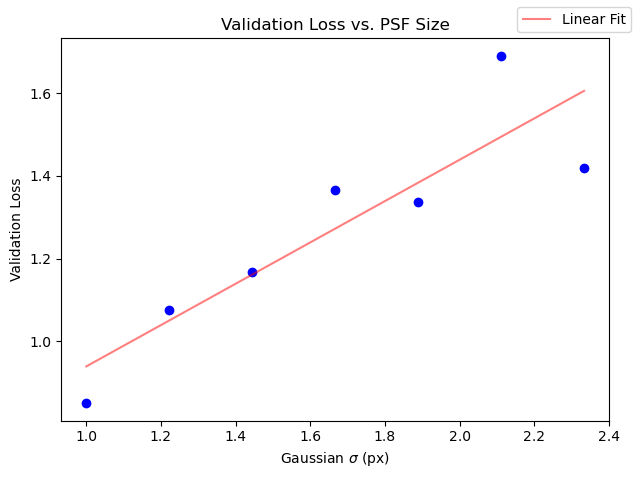

In [ ]:
fig, ax = plt.subplots()

idx = np.argsort(sigmas)
plot_sigmas = np.array(sigmas)[idx]
plot_losses = np.array(losses)[idx]
ax.plot(plot_sigmas, plot_losses, 'bo')
ax.set_ylabel('Validation Loss')
ax.set_title('Validation Loss vs. PSF Size')
ax.set_xlabel(r'Gaussian $\sigma$ (px)')

trend = np.poly1d(np.polyfit(plot_sigmas, plot_losses, 1))
ax.plot(plot_sigmas, trend(plot_sigmas), 'r', label='Linear Fit', alpha=0.5)

fig.legend()
fig.tight_layout()
plt.show()

## Image Noise Variation

In [2]:
N = 50000 # number of particles to simulate
epochs = 1

# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 32,
    "num_heads": 4,
    "hidden_dim": 64,
    "num_layers": 6,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "use_pos_embed": False,
    "use_segment_embed": True,
    "use_rotary": False
}

image_props = SINGLE_STATE_PROPS

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#NOISE_LEVELS = [0, 1/4, 1/2, 1, 2]
NOISE_LEVELS = np.linspace(0, 0.5, num=10)

Using device: cuda


### Train model on different noises

In [3]:
model_loss = []

for i, noise in enumerate(NOISE_LEVELS):
    if i == 0:
        image_props['gaussian_noise'] = False
    else:
        image_props['gaussian_noise'] = True
    
    image_props['background_intensity'][0] = noise * background_mean

    # Create new model   
    model = DiffusionTensorRegModelBase(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
        model_props['num_layers'], model_props['dropout'])
    # model = CrossAttentionModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
    #     model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
    #     use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props['use_rotary'])

    losses = []
    vlosses = []
    
    print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Noise level used: {NOISE_LEVELS[i]}")
    
    np.random.seed(150)
    train_single_mode(model, N, T, model_props, image_props, device, epochs, losses, vlosses, val_path='../data/validation_data_11.npz')
    #disp_stats = train_multi_modal(model, N, T, model_props, image_props, device, epochs, losses, vlosses, '../data/validation_data_11.npz')

    path = f'noise_models/single_state_{noise}_{N}_{epochs}_{model_props["embed_dim"]}_{model_props["lr"]}_{model_props["dropout"]}.pt'
    #"norm_stats": disp_stats,
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "background_sigma": noise * background_mean
    }
    torch.save(checkpoint, path)
    print(f"Saved model to path: {path}")
    
    model_loss.append(losses[-1]) # get training loss for model

Total params of DiffusionTensorRegModelBase: 346148
Noise level used: 0.0


Epochs of training: 100%|██████████| 1/1 [00:57<00:00, 57.16s/it]

Epoch 1/1 | Train Loss: 0.8149 | Val Loss: 1.7590
Saved model to path: noise_models/single_state_0.0_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Noise level used: 0.05555555555555555



Epochs of training: 100%|██████████| 1/1 [01:00<00:00, 60.64s/it]

Epoch 1/1 | Train Loss: 0.8274 | Val Loss: 1.2108
Saved model to path: noise_models/single_state_0.05555555555555555_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Noise level used: 0.1111111111111111



Epochs of training: 100%|██████████| 1/1 [01:00<00:00, 60.05s/it]

Epoch 1/1 | Train Loss: 0.8384 | Val Loss: 0.9955
Saved model to path: noise_models/single_state_0.1111111111111111_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Noise level used: 0.16666666666666666



Epochs of training: 100%|██████████| 1/1 [00:58<00:00, 58.47s/it]

Epoch 1/1 | Train Loss: 0.8924 | Val Loss: 0.8343
Saved model to path: noise_models/single_state_0.16666666666666666_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Noise level used: 0.2222222222222222



Epochs of training: 100%|██████████| 1/1 [01:00<00:00, 60.22s/it]

Epoch 1/1 | Train Loss: 0.8863 | Val Loss: 1.4895
Saved model to path: noise_models/single_state_0.2222222222222222_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Noise level used: 0.2777777777777778



Epochs of training: 100%|██████████| 1/1 [00:52<00:00, 52.51s/it]

Epoch 1/1 | Train Loss: 0.8954 | Val Loss: 0.8968
Saved model to path: noise_models/single_state_0.2777777777777778_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Noise level used: 0.3333333333333333



Epochs of training: 100%|██████████| 1/1 [00:56<00:00, 56.79s/it]

Epoch 1/1 | Train Loss: 0.9705 | Val Loss: 1.0617
Saved model to path: noise_models/single_state_0.3333333333333333_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Noise level used: 0.38888888888888884



Epochs of training: 100%|██████████| 1/1 [00:56<00:00, 56.73s/it]

Epoch 1/1 | Train Loss: 0.9358 | Val Loss: 0.7731
Saved model to path: noise_models/single_state_0.38888888888888884_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Noise level used: 0.4444444444444444



Epochs of training: 100%|██████████| 1/1 [01:00<00:00, 60.42s/it]

Epoch 1/1 | Train Loss: 0.9165 | Val Loss: 1.0609
Saved model to path: noise_models/single_state_0.4444444444444444_50000_1_32_0.0001_0.01.pt
Total params of DiffusionTensorRegModelBase: 346148
Noise level used: 0.5



Epochs of training: 100%|██████████| 1/1 [00:53<00:00, 53.99s/it]

Epoch 1/1 | Train Loss: 0.9133 | Val Loss: 1.1180
Saved model to path: noise_models/single_state_0.5_50000_1_32_0.0001_0.01.pt


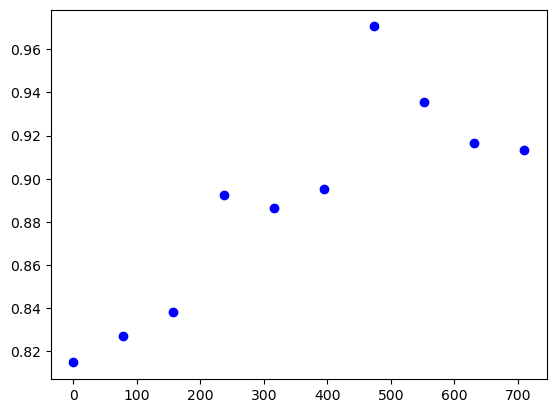

In [4]:
plt.plot([i * background_mean for i in NOISE_LEVELS], model_loss, 'bo')
plt.show()

single_state_0.4444444444444444_50000_1_32_0.0001_0.01.pt
--------------------------------------------------
Average loss across validation set: 0.9576145831946354
Average MAE of diffusion coefficients and angle simularity across validation set: [0.6406654  0.39737564 0.84368587]
Average L2-based similarity of diffusion tensors across validation set: 0.9615715742111206
--------------------------------------------------
single_state_0.3333333333333333_50000_1_32_0.0001_0.01.pt
--------------------------------------------------
Average loss across validation set: 1.0623679996296098
Average MAE of diffusion coefficients and angle simularity across validation set: [0.6301503  0.43972546 0.8234885 ]
Average L2-based similarity of diffusion tensors across validation set: 0.9598289728164673
--------------------------------------------------
single_state_0.2222222222222222_50000_1_32_0.0001_0.01.pt
--------------------------------------------------
Average loss across validation set: 1.4061423

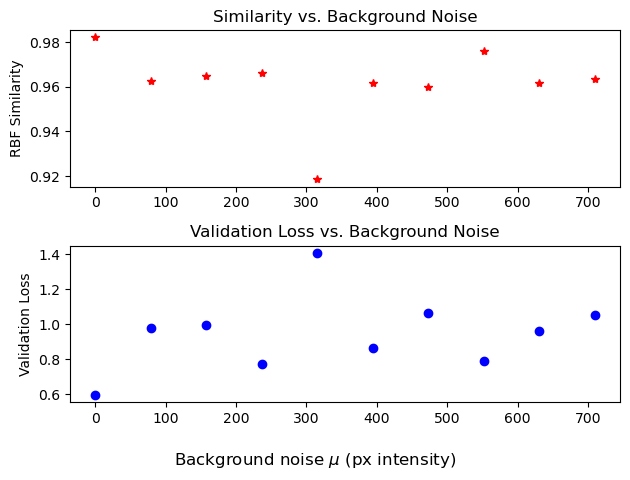

In [ ]:
import os
import re

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

losses = []
noises = []


for i, path in enumerate(os.listdir('noise_models')):
    noise_level = float(re.match(r'single_state_(\d\.*\d*)_.*', path).group(1))
    image_props['background_intensity'][0] = noise_level * background_mean
    noises.append(noise_level * background_mean)
    
    # Create new model 
    model = DiffusionTensorRegModelBase(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
        model_props['num_layers'], model_props['dropout'])  
    # model = CrossAttentionModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
    #     model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
    #     use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props['use_rotary'])

    checkpoint = torch.load('noise_models/' + path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    #disp_stats = checkpoint['norm_stats']
    model.to(device)
    
    if noise_level == 0:
        image_props['gaussian_noise'] = False
    else:
        image_props['gaussian_noise'] = True
        
    # all_videos, all_displacements, og_labels = create_training_set_w_features(N, T, image_props) 

    # avg_loss = single_state_eval(all_videos, all_displacements, og_labels, disp_stats, model, model_props, image_props, device)
    all_videos, og_labels = create_training_set(N, T, image_props)

    print(path, 50*'-', sep='\n')
    avg_loss = single_state_eval(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device)
    
    losses.append(avg_loss)

fig, ax = plt.subplots(2,1)

ax.plot(noises, losses, 'bo')
ax.set_ylabel('Validation Loss')
ax.set_title('Validation Loss vs. Background Noise')

fig.supxlabel(r'Background noise $\mu$ (px intensity)')
fig.tight_layout()
plt.show()

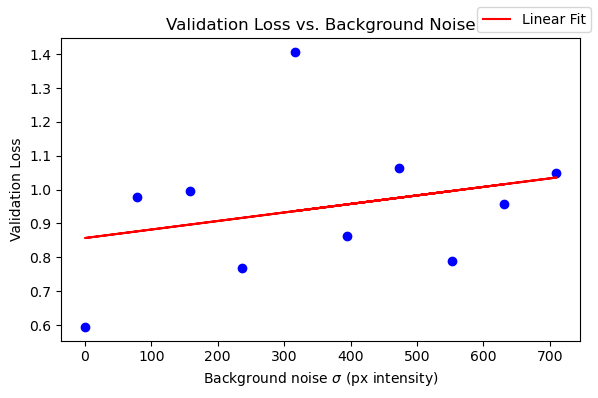

In [7]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(noises, losses, 'bo')
ax.set_ylabel('Validation Loss')
ax.set_title('Validation Loss vs. Background Noise')
ax.set_xlabel(r'Background noise $\sigma$ (px intensity)')

trend = np.poly1d(np.polyfit(noises, losses, 1))
ax.plot(noises, trend(noises), 'r', label='Linear Fit')

fig.tight_layout()
fig.legend()
plt.show()